In [3]:
import math
import numpy as np
import librosa
%matplotlib widget
import matplotlib.pyplot as plt

In [4]:
librosa.__version__

'0.10.1'

## **Kapre**

In [5]:
def filterbank_mel(
    sample_rate, n_freq, n_mels=128, f_min=0.0, f_max=None, htk=False, norm='slaney'
):
    """A wrapper for librosa.filters.mel that additionally does transpose and tensor conversion

    Args:
        sample_rate (`int`): sample rate of the input audio
        n_freq (`int`): number of frequency bins in the input STFT magnitude.
        n_mels (`int`): the number of mel bands
        f_min (`float`): lowest frequency that is going to be included in the mel filterbank (Hertz)
        f_max (`float`): highest frequency that is going to be included in the mel filterbank (Hertz)
        htk (bool): whether to use `htk` formula or not
        norm: The default, 'slaney', would normalize the the mel weights by the width of the mel band.

    Returns:
        (`Tensor`): mel filterbanks. Shape=`(n_freq, n_mels)`
    """
    filterbank = librosa.filters.mel(
        sr=sample_rate,
        n_fft=(n_freq - 1) * 2,
        n_mels=n_mels,
        fmin=f_min,
        fmax=f_max,
        htk=htk,
        norm=norm)
    
    return filterbank

In [6]:
def filterbank_log(sample_rate, n_freq, n_bins=84, bins_per_octave=12, f_min=None, spread=0.125):
    """A function that returns a approximation of constant-Q filter banks for a fixed-window STFT.
    Each filter is a log-normal window centered at the corresponding frequency.

    Args:
        sample_rate (`int`): audio sampling rate
        n_freq (`int`): number of the input frequency bins. E.g., `n_fft / 2 + 1`
        n_bins (`int`): number of the resulting log-frequency bins.  Defaults to 84 (7 octaves).
        bins_per_octave (`int`): number of bins per octave. Defaults to 12 (semitones).
        f_min (`float`): lowest frequency that is going to be included in the log filterbank. Defaults to `C1 ~= 32.70`
        spread (`float`): spread of each filter, as a fraction of a bin.

    Returns:
        (`Tensor`): log-frequency filterbanks. Shape=`(n_freq, n_bins)`

    Note:
        The code is originally from `logfrequency` in librosa 0.4 (deprecated) and copy-and-pasted.
        `tuning` parameter was removed and we use `n_freq` instead of `n_fft`.
    """

    if f_min is None:
        f_min = 32.70319566

    f_max = f_min * 2 ** (n_bins / bins_per_octave)
    if f_max > sample_rate // 2:
        raise RuntimeError(
            'Maximum frequency of log filterbank should be lower or equal to the maximum'
            'frequency of the input (defined by its sample rate), '
            'but f_max=%f and maximum frequency is %f. \n'
            'Fix it by reducing n_bins, increasing bins_per_octave and/or reducing f_min.\n'
            'You can also do it by increasing sample_rate but it means you need to upsample'
            'the input audio data, too.' % (f_max, sample_rate)
        )

    # What's the shape parameter for our log-normal filters?
    sigma = float(spread) / bins_per_octave

    # Construct the output matrix
    basis = np.zeros((n_bins, n_freq))

    # Get log frequencies of bins
    log_freqs = np.log2(librosa.fft_frequencies(sr=sample_rate, n_fft=(n_freq - 1) * 2)[1:])

    for i in range(n_bins):
        # What's the center (median) frequency of this filter?
        c_freq = f_min * (2.0 ** (float(i) / bins_per_octave))

        # Place a log-normal window around c_freq
        basis[i, 1:] = np.exp(
            -0.5 * ((log_freqs - np.log2(c_freq)) / sigma) ** 2 - np.log2(sigma) - log_freqs
        )

    # Normalize the filters
    basis2 = librosa.util.normalize(basis, norm=1, axis=1)
    
    return basis, basis2

In [7]:
filter_log, filter_log_norm = filterbank_log(sample_rate=16000, n_freq=2048//2+1, n_bins=84, bins_per_octave=12, f_min=None, spread=0.125)
filter_mel = filterbank_mel(sample_rate=16000, n_freq=2048//2+1, n_mels=128, f_min=0.0, f_max=None, htk=False, norm='slaney')

### **log**

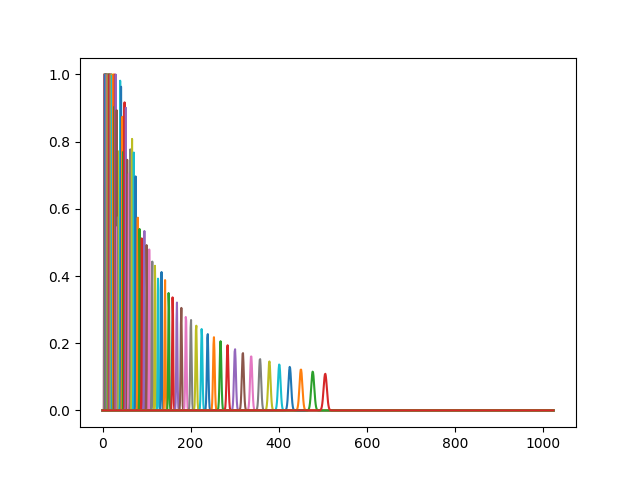

In [9]:
plt.figure()
plt.plot(filter_log_norm.T)
plt.show()

### **mel**

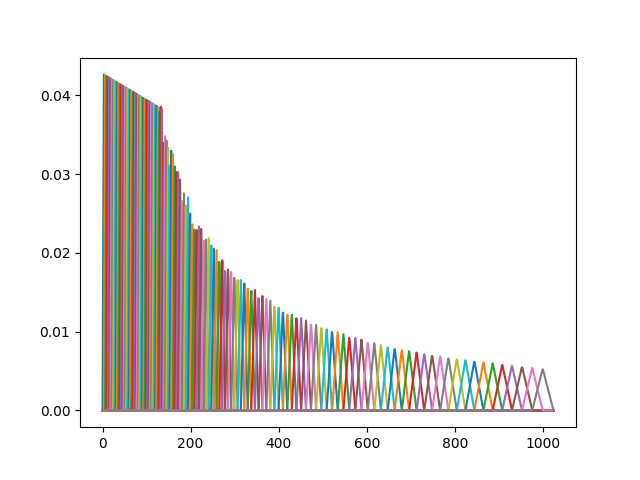

In [ ]:
plt.figure()
plt.plot(filter_mel.T)
plt.show()

## Meu filterbank

In [ ]:
def getOctaveFilterBank(fs=16000, Nfft=4096, Nfpo=12, fmin_user=None, fmax_user=None, edges=''):
    if fmin_user is None:
        fmin_user = 440 * 2 ** (((1 + 1) * 12 + 0 - 69) / 12)
    if fmax_user is None:
        fmax_user = 440 * 2 ** (((8 + 1) * 12 + 9 - 69) / 12)
    if edges == '':
        edges_flag = False
    else:
        edges_flag = True

    if fmax_user > fs / 2:
        fmax_user = fs / 2

    i0 = np.ceil(Nfpo * np.log2(fmin_user / 440))
    fmin = 440 * 2 ** (i0 / Nfpo)

    i = np.floor(-i0 + Nfpo * (np.log2(fmax_user / 440)))
    Nb = int(i - 1)
    fmax = 440 * 2 ** ((i + i0) / Nfpo)

    i = np.arange(Nb + 2)
    fi = fmin * 2 ** (i / Nfpo)

    H = np.zeros((Nb, Nfft // 2 + 1))
    fcf = np.zeros(Nb)

    k = np.arange(Nfft // 2 + 1)
    f = k * fs / Nfft

    for j in range(Nb):
        fLow = fi[j]
        fcf[j] = fi[j + 1]
        fUpp = fi[j + 2]

        H[j, :] = ((f - fLow) / (fcf[j] - fLow)) * ((f > fLow) & (f <= fcf[j])) + \
                  ((f - fUpp) / (fcf[j] - fUpp)) * ((f > fcf[j]) & (f <= fUpp))

    if edges_flag:
        fcf = np.concatenate(([fmin], fcf, [fmax]))

    return H, fcf

In [ ]:
H, fcf = getOctaveFilterBank()
print(H.shape)
print(fcf)

(92, 2049)
[  34.64782887   36.70809599   38.89087297   41.20344461   43.65352893
   46.24930284   48.9994295    51.9130872    55.           58.27047019
   61.73541266   65.40639133   69.29565774   73.41619198   77.78174593
   82.40688923   87.30705786   92.49860568   97.998859    103.82617439
  110.          116.54094038  123.47082531  130.81278265  138.59131549
  146.83238396  155.56349186  164.81377846  174.61411572  184.99721136
  195.99771799  207.65234879  220.          233.08188076  246.94165063
  261.6255653   277.18263098  293.66476792  311.12698372  329.62755691
  349.22823143  369.99442271  391.99543598  415.30469758  440.
  466.16376152  493.88330126  523.2511306   554.36526195  587.32953583
  622.25396744  659.25511383  698.45646287  739.98884542  783.99087196
  830.60939516  880.          932.32752304  987.76660251 1046.5022612
 1108.73052391 1174.65907167 1244.50793489 1318.51022765 1396.91292573
 1479.97769085 1567.98174393 1661.21879032 1760.         1864.65504607
 197

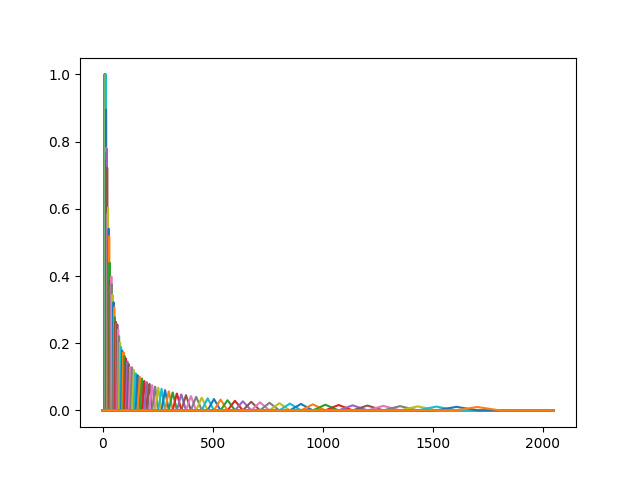

In [ ]:
plt.figure()
plt.plot(librosa.util.normalize(H, norm=1, axis=1).T)
plt.show()